In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/pheme/pheme-dataset.csv'
# test_path = '/content/drive/MyDrive/Fakenews/test.csv'

df = pd.read_csv(path)
df.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,text,target
0,0,"Breaking: At least 10 dead, 5 injured after tO...",1
1,1,France: 10 people dead after shooting at HQ of...,1
2,2,Ten killed in shooting at headquarters of Fren...,1
3,3,BREAKING: 10 dead in shooting at headquarters ...,1
4,4,Reuters: 10 people shot dead at headquarters o...,1


In [2]:
print(df.shape)
df.isna().sum()

(1705, 3)


Unnamed: 0    0
text          0
target        0
dtype: int64

,text,target
0,Jason Kenney says Canadians soldier shot at Wa...,1
1,@CBCNews has independently confirmed gunman ki...,1
2,Australian police cordon off Sydney street; re...,1
3,Several MPs tweeting that lone gunman shot dea...,1
4,Soldier killed in #OttawaShooting identified a...,1
...,...,...
1700,BREAKING NEWS: OTTAWA POLICE CONFIRM TO ABC NE...,0
1701,Swiss museum confirms it will take on #Gurlitt...,1
1702,Ottawa shootings reportedly at three locations...,1
1703,Update: Five hostages escape as a gunman conti...,1


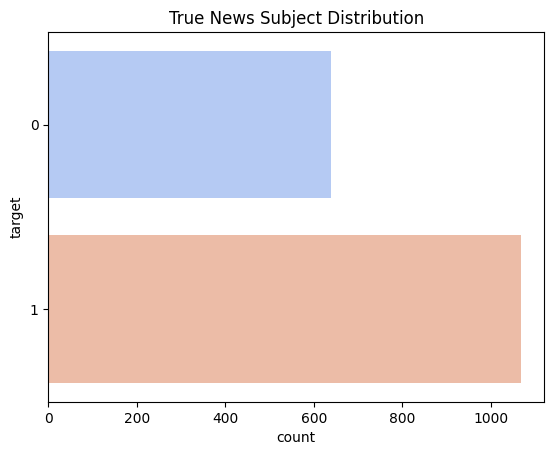

In [3]:
from sklearn.utils import shuffle

df = df[['text','target']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="target", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1705 non-null   object
 1   target  1705 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.8+ KB


In [5]:
df.drop_duplicates(subset=['text'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1699 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1699 non-null   object
 1   target  1699 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.8+ KB


In [6]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.875)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (1189, 2)
valset size: (170, 2)
testset size: (340, 2)


In [7]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [8]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 1189
valset size: 170
testset size:  340


In [10]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
#BREAKING: Trocadero square in Paris is evacuated. Unconfirmed reports of a gunman there http://t.co/XWREHWQuxs

tokens: 
['[CLS]', '#', 'breaking', ':', 'tr', '##oca', '##der', '##o', 'square', 'in', 'paris', 'is', 'evacuated', '.', 'un', '##con', '##firmed', 'reports', 'of', 'a', 'gun', '##man', 'there', 'http', ':', '/', '/', 't', '.', 'co', '/', 'x', '##wr', '##eh', '##w', '##qu', '##x', '##s', '[SEP]']

label: 0

--------------------

tokens_tensor: 
tensor([  101,  1001,  4911,  1024, 19817, 24755,  4063,  2080,  2675,  1999,
         3000,  2003, 13377,  1012,  4895,  8663, 23141,  4311,  1997,  1037,
         3282,  2386,  2045,  8299,  1024,  1013,  1013,  1056,  1012,  2522,
         1013,  1060, 13088, 11106,  2860, 28940,  2595,  2015,   102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
0




In [11]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [12]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [13]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2
# dropout_rate = 0.1
model = BertForSequenceClassification.from_pretrained(
    # PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS, hidden_dropout_prob=dropout_rate)
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [14]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
NUM_EPOCHS = 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(trainloader) * NUM_EPOCHS)

start_time = time.time()

best_val_acc = 0.0
best_model = None


for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

        scheduler.step()

    # model.eval()
    # val_loss = 0.0
    # val_acc = 0.0
    # with torch.no_grad():
    #     for data in valloader:
    #         tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
    #         outputs = model(input_ids=tokens_tensors, 
    #                         token_type_ids=segments_tensors, 
    #                         attention_mask=masks_tensors, 
    #                         labels=labels)
    #         loss = outputs[0]
    #         logits = outputs[1]
    #         _, pred = torch.max(logits.data, 1)
    #         val_acc += accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
    #         val_loss += loss.item()

    # val_acc /= len(valloader)
    # val_loss /= len(valloader)

    # print(f"Validation accuracy: {val_acc}, Validation loss: {val_loss}")

    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     best_model = model.state_dict()
    #     torch.save(best_model, './best_model.pth')
    # model.train()
end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

In [15]:
torch.save(model, './best_model.pth')

BERT Model Accuracy :  0.8941176470588236
Precision :  0.9162790697674419
Recall :  0.9162790697674419
F1 :  0.916279069767442
G-mean: 0.8856268309626409
Training time:  56.017492055892944
Inference time:  1.4026103019714355
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       125
           1       0.92      0.92      0.92       215

    accuracy                           0.89       340
   macro avg       0.89      0.89      0.89       340
weighted avg       0.89      0.89      0.89       340



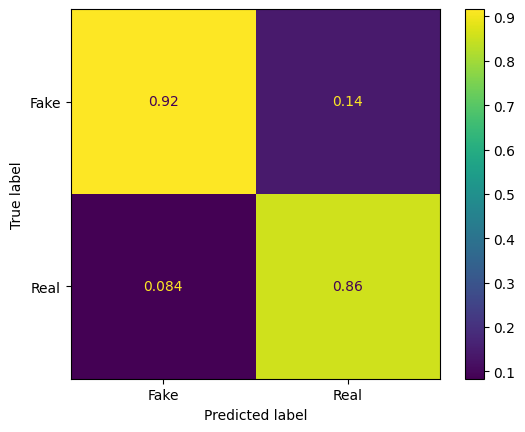

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()